# Задание

### Предсказания стоимости машин по VIN коду.

##### План:
1. Загрузка данных
2. Парсинг
4. Исследовательский анализ данных
5. Обучение модели
6. Результаты

In [1]:
# import os
# os.environ['REQUESTS_CA_BUNDLE'] = r'C:\Users\Navi\anaconda3\ssl\cacert-2024-03-11.pem'

In [2]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org optuna (установка напрямую без pem)

### 1. Загрузка данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from optuna.integration import OptunaSearchCV
import optuna
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor

In [4]:
import pandas as pd
import re

In [5]:
with open ('vin_ford_train.txt', 'r') as f:
    content = f.read()

In [6]:
content[:500]

'[2FMDK3JC4BBA41556:12500]РјРѕР№[3FA6P0H75ER208976:14500]РґСЏРґСЏ [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]СЃР°РјС‹С… [1FAHP2E89DG119368:11600] РІРµСЂРЅС‹С…[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZU64W13UC28949:2900][2FMDK3JC9DBB30736:23500][1FMCU9D76CKC49193:12700][1FMCU9EG2CKA90624:20700][1FMCU0JX7EUA28208:21300][2FMGK5D85EBD31213:26700][2FMDK4KC6EBA72011:25100]РїСЂР°РІРёР» [1FTFX1EF2EKE24350:26700][1ZVBP8EM0D5237253:11600]'

In [7]:
# data = pd.read_csv('vin_ford_train.txt', delimiter='\t')   

### 2. Парсинг

##### VIN американских авто

- `1-3` производитель 
- `4` ремни безопасности для пассажиров, тормоза и грузоподьемность у трака
- `5-7` - модель
- `8` - двигатель
- `9` - контрольный знак 
- `10` - год
- `11` - завод производитель
- `12-17` - серийный номер

##### Разрешенные символы
Код создает список допустимых символов для VIN, и включает в него все буквы от A до Z, исключая I, O и Q, а также все цифры от 0 до 9, кроме 1. Затем он объединяет все символы в строку. Давайте проверим, что получится:

In [8]:
ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')]
ALLOWED_NUMS = [str(x) for x in range(1,10)] + ['0']

allowed = ''.join(ALLOWED_CHARS+ALLOWED_NUMS)
allowed

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

- `WMI_RE`: Это регулярное выражение сопоставляет первые три символа VIN-кода (World Manufacturer Identifier, WMI). {3} указывает на то, что должны быть точно три символа. allowed представляет допустимые символы для WMI.
- `RESTRAINT_RE`: Это регулярное выражение сопоставляет следующий символ VIN-кода, который обозначает ограничения (например, тип кузова).
- `MODEL_RE`: Это регулярное выражение сопоставляет следующие три символа VIN-кода, которые представляют модель автомобиля.
- `ENGINE_RE`: Это регулярное выражение сопоставляет следующий символ VIN-кода, который представляет тип двигателя.
- `CHECK_RE`: Это регулярное выражение сопоставляет следующий символ VIN-кода, который является проверочным.
- `YEAR_RE`: Это регулярное выражение сопоставляет следующий символ VIN-кода, который представляет год выпуска автомобиля. В данном случае используется замена символов "U" и "Z", так как они обычно используются в качестве года в VIN-кодах.
- `PLANT_RE`: Это регулярное выражение сопоставляет следующий символ VIN-кода, который представляет завод-изготовитель автомобиля.
- `VIS_RE`: Это регулярное выражение сопоставляет следующие шесть символов VIN-кода, которые представляют серийный номер транспортного средства.
- `vin_re`: Это основное регулярное выражение, которое объединяет все предыдущие регулярные выражения для полного сопоставления VIN-кода.
- `price_re`: Это регулярное выражение для сопоставления цены, представленной в виде последовательности цифр.
- `data_re`: Это регулярное выражение, которое сопоставляет полную строку данных, содержащую VIN-код и цену.

In [9]:
WMI_RE = f'(?P<wmi>[{allowed}]{{3}})'                                  # 1-3 в коде VIN
RESTRAINT_RE = f'(?P<restraint>[{allowed}])'                           # 4 
MODEL_RE = f'(?P<model>[{allowed}]{{3}})'                              # 5-7 
ENGINE_RE = f'(?P<engine>[{allowed}])'                                 # 8 
CHECK_RE = f'(?P<check>[{allowed}])'                                   # 9 
YEAR_RE = f'(?P<year>[{allowed.replace("U", "").replace("Z", "")}])'   # 10 
PLANT_RE = f'(?P<plant>[{allowed}])'                                   # 11 
VIS_RE = f'(?P<vis>[{allowed}]{{3}}\\d{{3}})'                          # 12-17 

vin_re = f'{WMI_RE}{RESTRAINT_RE}{MODEL_RE}{ENGINE_RE}{CHECK_RE}{YEAR_RE}{PLANT_RE}{VIS_RE}'
price_re = r'(?P<price>\d+)'

data_re = re.compile(f'\\[{vin_re}:{price_re}\\]')

Цикл ниже делает итерации по всем совпадениям регулярного выражения `data_re` в содержимом файла. `data_re.finditer(content)` возвращает итератор, который проходит по всем совпадениям в строке content. Далее, для каждого совпадения создается словарь с помощью метода `groupdict()`, который возвращает словарь с именованными группами совпадения. Этот словарь добавляется в список values.

In [10]:
values = []
for obj in data_re.finditer(content):
    values.append(obj.groupdict())

values[:1]

[{'wmi': '2FM',
  'restraint': 'D',
  'model': 'K3J',
  'engine': 'C',
  'check': '4',
  'year': 'B',
  'plant': 'B',
  'vis': 'A41556',
  'price': '12500'}]

In [11]:
df = pd.DataFrame(values)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   vis        71884 non-null  object
 8   price      71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


In [13]:
df.head()

,wmi,restraint,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


In [14]:
df['price'] = df['price'].astype(float)

### 4. Исследовательский анализ данных
 

In [30]:
df.isna().sum()

wmi          0
restraint    0
model        0
engine       0
check        0
year         0
plant        0
vis          0
price        0
dtype: int64

C:\Users\Navi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


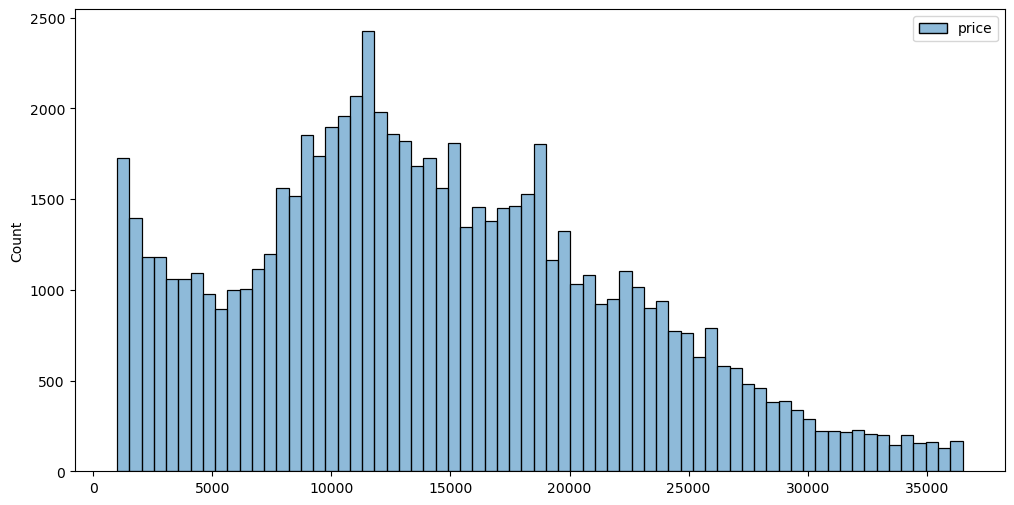

In [15]:
plt.figure(figsize=(12,6))
sns.histplot(data=df)
plt.show()

Распределение таргета не нормальное

Убираем выбросы с помщью метода `LocalOutlierFactor()`

In [16]:
lof_model = LocalOutlierFactor()

X_train = df[['price']]

lof_model.fit(X_train)

outliers = lof_model.fit_predict(X_train)

df = df[outliers != -1]

### 5. Обучение модели


In [18]:
df.columns

Index(['wmi', 'restraint', 'model', 'engine', 'check', 'year', 'plant', 'vis',
       'price'],
      dtype='object')

Используем CatBoost для предсказания цены 

In [22]:
features = df[['wmi', 'restraint', 'model', 'engine', 'check', 'year', 'plant', 'vis']]
target = df['price']
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=42)

cat_cols=['wmi', 'restraint', 'model', 'engine', 'check', 'year', 'plant', 'vis']

param = {
    'learning_rate': optuna.distributions.FloatDistribution(1e-4, 1, log=True),
    'iterations': optuna.distributions.IntDistribution(800, 1200),
    'depth': optuna.distributions.IntDistribution(1, 10),
    'min_data_in_leaf': optuna.distributions.IntDistribution(1, 10),
    'subsample': optuna.distributions.FloatDistribution(0.7, 0.9),
    'colsample_bylevel': optuna.distributions.FloatDistribution(0.05, 1.0),
}

clf = CatBoostRegressor(verbose=False)

optuna_search = OptunaSearchCV(clf, 
                               param, 
                               cv=3,
                               n_trials=50, 
                               scoring='neg_root_mean_squared_error', 
                               timeout=500,
                               verbose=5,
                               n_jobs=-1)

optuna_search.fit(features_train, 
                  target_train, 
                  cat_features=cat_cols)

print("Best RMSE:", -optuna_search.best_score_)
print("Best parameters:", optuna_search.best_params_)

predictions = optuna_search.predict(features_test)

rmse = mean_squared_error(target_test, predictions, squared=False)
print("RMSE on test set:", rmse)


C:\Users\Navi\AppData\Local\Temp\ipykernel_21552\2131168837.py:26: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(clf,
[I 2024-04-21 20:37:19,584] A new study created in memory with name: no-name-5e90f0c6-aba3-4109-92dc-df64a34d4b6e
[I 2024-04-21 20:38:38,013] Trial 1 finished with value: -6684.4904235811955 and parameters: {'learning_rate': 0.00026218190991672525, 'iterations': 1156, 'depth': 2, 'min_data_in_leaf': 4, 'subsample': 0.8438546002532827, 'colsample_bylevel': 0.3328432072232785}. Best is trial 1 with value: -6684.4904235811955.
[I 2024-04-21 20:38:56,409] Trial 2 finished with value: -2816.465164715411 and parameters: {'learning_rate': 0.23640999028005896, 'iterations': 953, 'depth': 4, 'min_data_in_leaf': 8, 'subsample': 0.7772790807306291, 'colsample_bylevel': 0.1347395106875391}. Best is trial 2 with value: -2816.465164715411.
[I 2024-04-21 20:39:13,360] Trial 6 finis

Best RMSE: 2788.8163069541383
Best parameters: {'learning_rate': 0.028818832559670122, 'iterations': 849, 'depth': 9, 'min_data_in_leaf': 8, 'subsample': 0.7215109564384677, 'colsample_bylevel': 0.2680803305478521}
RMSE on test set: 2727.167930334189


Проверим лучше ли наша модель чем dummy 

In [41]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy='mean')  # Используем стратегию среднего значения
dummy_model.fit(features_train, target_train)

dummy_predictions = dummy_model.predict(features_test)

dummy_rmse = mean_squared_error(target_test, dummy_predictions, squared=False)
print("RMSE on test (dummy model):", dummy_rmse)

RMSE on test (dummy model): 7706.838090265152


Смотрим на R2 для лучшего понимания результатов

In [43]:
r2 = r2_score(target_test, predictions)
print("R2 on test:", r2)

R2 on test: 0.874776699210839


Модель успешно обьясняет 87 процентов данных

Смотрим на важность признаков (feature_importances)

In [29]:
feature_importances = optuna_search.best_estimator_.feature_importances_
print("Feature Importances:")
for i, feature in enumerate(features.columns):
    print(f"{feature}: {feature_importances[i]}")

Feature Importances:
wmi: 8.674799252348544
restraint: 15.37508568076815
model: 20.629380159145903
engine: 16.17436025671187
check: 2.589835978208425
year: 26.498443090472858
plant: 9.905856214267011
vis: 0.15223936807722982


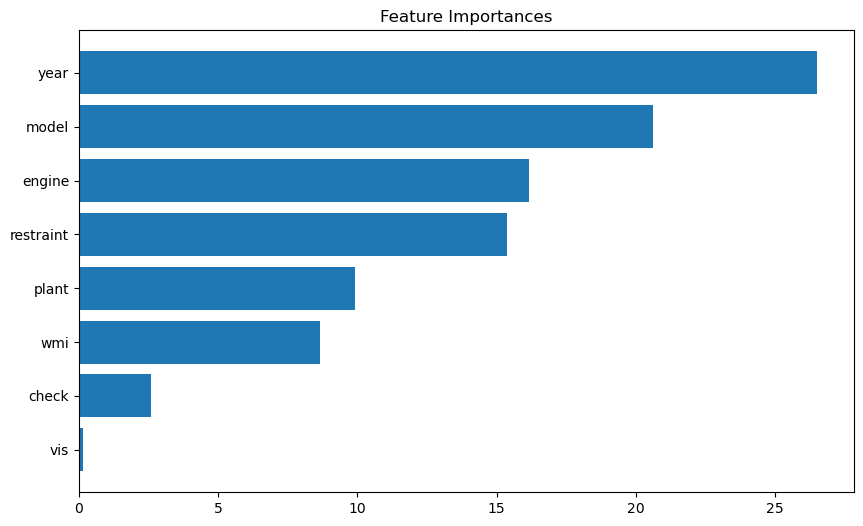

In [34]:
feature_importance = optuna_search.best_estimator_.feature_importances_

importance_df = pd.DataFrame({'Feature': cat_cols, 
                              'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance')

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], 
         importance_df['Importance'])
plt.title('Feature Importances')
plt.show()


### 6. Результаты

- Сделали парсинг данных VIN автомобилей. 
- Предобработали данные(изменили тип данных/ обработали выбросы)
- Обучили модель CatBoost.
- Результат модели предсказания на тестовой выборке:
     - RMSE: 2727.167930334189
     - R2: 0.874776699210839  